In [1]:
import itertools
import sys
import os
import h5py
from pprint import pprint
import numpy as np
from numpy import ma
from copy import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator, LinearLocator, FormatStrFormatter, LogLocator, LogFormatterExponent, ScalarFormatter
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid', {'axes.linewidth': '1', 'axes.edgecolor': '0.15'})
sns.set_style("ticks")
current_palette = sns.color_palette()

In [2]:
#https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib/20146989#20146989
class MidPointLogNorm(LogNorm):
    '''
    '''
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

In [3]:
class mplot4d(object):
    def __init__(self, h5gridprefix = None, idb=0, idt=10, iqn = 26, iqp = 35,
                 defpath = r'/home/ben/git/ndust/data/'):
        '''
        '''
        self.defpath = defpath

        self.h5gridprefix = h5gridprefix
        self.h5gridprefix = self.defpath + self.h5gridprefix

        # Read grid file
        self.gridfname = self.h5gridprefix + '.h5'
        self.gridfile =  h5py.File(self.gridfname, 'r')

        ## group volumes
        self.gvols = self.gridfile.get("Volume_sections")
        self.vifaces = np.array(self.gvols.get("Interfaces"))

        ## interfaces in diameters nm
        self.vifaces_diam = np.power(6.0*self.vifaces/np.pi, 1.0/3.0)*1E9

        ## WARNING diameter pivots in nanometres
        self.vpivots = np.array(self.gvols.get("Volumes"))

        ## pivots in diameters
        self.dpivots = np.array(self.gvols.get("Diameters"))*1E9

        ## group charges
        self.gchgs = self.gridfile.get("Charge_sections")

        self.qpivots = np.array(self.gchgs.get("Charges"))
        #self.qifaces = np.append()
        #np.array(self.gchgs.get("qifaces"))

        self.idb = []
        self.idt = []
        self.iqn = []
        self.iqp = []
        self.set_grid(idb, idt, iqn, iqp)

        self.gcoagulation = self.gridfile.get("Coagulation_rate")
        self.gefactor = self.gridfile.get("Enhancement_factor")
        self.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
        self.hatches=['/', *[None]*(len(self.loglevels)-1)]
        self.hsize = []
        self.vsize = []
        
        self.logvmin = -4
        self.logvmax = 4
        self.minvalue = 10**self.logvmin

        self.contour_width = 1.5
        self.linecharge_width = 1.5

    def sci_fmt(self, x, pos):
        ''' Scientific format
        '''
        # WORKING
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        if a==0:
            return r'${{}}$'.format(a)
        else:
            return r'$10^{{{}}}$'.format(b)

    def set_grid(self, idb, idt, iqn, iqp):
        self.idb = idb# index for minimum diameter
        self.idt = idt# index for maximum diameter
        self.iqn = iqn# index for negative charges
        self.iqp = iqp# index for positive charges
        # make grid
        self.X, self.Y = np.meshgrid(self.dpivots[idb:idt+1], self.qpivots[iqn:iqp+1])
        self.extents_linear = [0, len(self.dpivots[idb:idt+1]), 0, len(self.qpivots[iqn:iqp+1])]

    def get(self, name):
        efactor = np.array(self.gefactor.get(name))
        # get one dataset for testing    
        result = np.array(self.gcoagulation.get(name))
        res_gt_0 = result > 0
        log10res = np.zeros_like(result)
        log10res[res_gt_0] = np.log10(result[res_gt_0])
        return result, log10res, efactor

    def close(self):
        self.gridfile.close()

    def plot_fcontours(self, ax, data, levelsf=None, cmap=cm.plasma):
        """
        """
        if levelsf is None:
            levelsf = np.arange(1, 18, 2)

        norm = mpl.colors.Normalize(vmin=levelsf[0], vmax=levelsf[-1])
        
        # restrict data to grid
        datagrid = data[self.iqn:self.iqp+1, self.idb:self.idt+1]

        CSF = ax.contourf(self.X, self.Y, datagrid, levelsf, cmap=cmap,
                          origin='lower', norm=norm, extent=self.extents_linear,
                          hatches=self.hatches, extend='max')
        CS = ax.contour(self.X, self.Y, datagrid, levels=levelsf, origin='lower',
                        colors='k', linewidths=self.contour_width)
        return CSF, CS

    def plot_fcontours_symlog(self, ax, data, levelsf=None, cmap=cm.coolwarm_r):
        """
        """
        if levelsf is None:
            levelsf = np.logspace(self.logvmin, self.logvmax,
                                  num=-self.logvmin+self.logvmax+1, base=10)

        vmin = levelsf[0]
        vmax=levelsf[-1]
        
        #norm = mpl.colors.LogNorm(vmin=levelsf.min(), vmax=levelsf.max())
        norm = MidPointLogNorm(clip=False, midpoint=1.0, vmin=vmin, vmax=vmax)
       
        # restrict data to grid
        datagrid = data[self.iqn:self.iqp+1, self.idb:self.idt+1]

        CSF = ax.contourf(self.X, self.Y, datagrid, levels=levelsf, cmap=cmap, vmin=vmin, vmax=vmax,
                          norm=norm)
        
        CS = ax.contour(self.X, self.Y, datagrid, levels=levelsf, colors='k', linewidths=self.contour_width)
        
        return CSF, CS, levelsf

    def plot(self, llist, qlist, levelsf=np.logspace(0, 3, 20), xaxticks=None,
             yaxticks=None, filename='name', hsize=None, vsize=None):
        data = []
        
        for ll in llist:
            for ql in qlist:
                # iterate in datasets of gefactor
                for ds in self.gefactor.keys():
                    lp = self.gefactor.get(str(ds)).attrs.get('l')
                    qp = self.gefactor.get(str(ds)).attrs.get('q')
                    if(ll==lp and ql==qp):
                        data.append(np.array(self.gefactor.get(str(ds))))
        if not hsize:
            self.hsize = len(qlist)*4.5
        else:
            self.hsize = hsize
        if not vsize:
            self.vsize = len(llist)*3.5
        else:
            self.vsize = vsize

        fig, axes = plt.subplots(nrows=len(qlist), ncols=len(llist), figsize=(self.hsize, self.vsize))

        for ax in axes.flat:
            # Hide all ticks and labels
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            
        i=0
        for j, (col, l) in enumerate(zip(axes.T, llist)):
            if(len(qlist)>1):
                for ax, q in zip(col, qlist):        
                    CSF, CS = self.plot_fcontours(ax, data[i], levelsf=self.loglevels, cmap=cm.gist_heat_r)
                    i = i+1
            else:
                CSF, CS = self.plot_fcontours(axes[j], data[j], levelsf=self.loglevels, cmap=cm.gist_heat_r)

        if(len(qlist)>1):
            axes[len(col)-1, 0].xaxis.set_visible(True)
            axes[len(col)-1, 0].set_xlabel('Diameter of particle 1 (nm)', size=16)
            axes[len(col)-1, 0].yaxis.set_visible(True)
            axes[len(col)-1, 0].set_ylabel('Charge of particle 1 (e)', size=16)
            axes[len(col)-1, 0].yaxis.set_ticks_position('left')
        
        for ax in axes.flat:
            ax.xaxis.set_visible(True)
            ax.yaxis.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            ax.set_yticks(self.Y[:, 0])
            if xaxticks:
                ax.set_xticks(xaxticks)
                ax.set_xlim([xaxticks[0], xaxticks[-1]])
            if yaxticks:
                ax.set_yticks(yaxticks)
                ax.get_yaxis().set_major_formatter(ScalarFormatter())
                ax.set_ylim([yaxticks[0], yaxticks[-1]])
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

        if(len(qlist)>1):
            for ax, l in zip(axes[0], llist):
                ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
                ax.yaxis.set_visible(True)

            for ax, q in zip(axes[:, -1], qlist):
                ax.set_ylabel('{:+.0f}'.format((self.qpivots[q])), size=16, rotation=270, labelpad=20)
                ax.yaxis.set_label_position("right")
                ax.xaxis.set_visible(True)
                for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14)
        else:
            for ax, l in zip(axes, llist):
                ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
                ax.yaxis.set_visible(True)

            ax = axes[0]
            ax.xaxis.set_visible(True)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            ax.xaxis.set_visible(True)
            ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
            ax.yaxis.set_visible(True)
            ax.set_ylabel('Charge of particle 1 (e)', size=16)
            ax.yaxis.set_ticks_position('left')

        if(len(qlist)>1):
            plt.gcf().text(0.3, 0.92,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
            plt.gcf().text(0.72, 0.64,"Charge of particle 2 (e)", ha="left", fontsize=20, rotation=-90)
        else:
            plt.gcf().text(0.3, 1,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
            #plt.gcf().text(0.75, 0.8,"Charge of particle 2 (e)", ha="left", fontsize=20, rotation=-90)
        
        cbpad = 0.12
        if(len(qlist)==1):
            cbpad = 0.04
        CB = fig.colorbar(CSF, ax=axes.ravel().tolist(), pad=cbpad)
        CB.add_lines(CS)
            
        CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=20, labelpad=20)
        CB.ax.tick_params(labelsize=14)
        
        plt.savefig(filename+'.eps')
        plt.show()
        #
    #
    #
    def plot_fsymlog_c(self, llist, qlist, levelsf=None, xaxticks=None,
                     yaxticks=None, filename='name', hsize=None, vsize=None, mean_charge=None):
        data_orig = []
        
        for ll in llist:
            for ql in qlist:
                # iterate in datasets of gefactor
                for ds in self.gefactor.keys():
                    lp = self.gefactor.get(str(ds)).attrs.get('l')
                    qp = self.gefactor.get(str(ds)).attrs.get('q')
                    if(ll==lp and ql==qp):
                        data_orig.append(np.array(self.gefactor.get(str(ds))))
        # prune data
        data = np.copy(data_orig)        
        #data[data<1e-4]=1e-4
        
        if not hsize:
            self.hsize = len(qlist)*4.5
        else:
            self.hsize = hsize
        if not vsize:
            self.vsize = len(llist)*3.5
        else:
            self.vsize = vsize

        fig, axes = plt.subplots(nrows=len(qlist), ncols=len(llist), figsize=(self.hsize, self.vsize))

        for ax in axes.flat:
            # Hide all ticks and labels
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            if mean_charge:
                ax.plot(mean_charge[0], mean_charge[1], '-w', linewidth=self.linecharge_width)
                ax.plot(mean_charge[2], mean_charge[3], '-.w', linewidth=self.linecharge_width)#, color='#BEBEBE')
                ax.plot(mean_charge[4], mean_charge[5], '-.w', linewidth=self.linecharge_width)

        mini = self.logvmin
        maxi = self.logvmax
        levelsf2 = np.logspace(mini, maxi, num=256, base=10)
        levelsf3 = np.logspace(mini, maxi, num=-mini+1+maxi, base=10)

        #levelsf4 = np.array([1e-3, 1e-2, 1e-1, 1, 10, 20, 50, 100, 200, 500, 1000, 10000])
        levelsf4 = np.copy(levelsf3)
        
        palette = copy(cm.coolwarm_r)
        #palette.set_over('b', 1.0)
        #palette.set_under('r', 0.0)
        
        i=0
        for j, (col, l) in enumerate(zip(axes.T, llist)):
            if(len(qlist)>1):
                for ax, q in zip(col, qlist):        
                    datagrid = data[i][self.iqn:self.iqp+1, self.idb:self.idt+1]
                    trimmed = np.copy(datagrid)
                    trimmed[datagrid<self.minvalue]=self.minvalue
                    vmin = levelsf2.min()
                    vmax = levelsf2.max()
                    CSF = ax.contourf(self.X, self.Y, trimmed, cmap=palette, levels=levelsf2,
                                      norm=MidPointLogNorm(clip=False,midpoint=1.0, vmin=vmin, vmax=vmax),
                                      vmin=vmin, vmax=vmax)

#                     vmin=1e-3
#                     vmax=1e3
#                     norm = mpl.colors.LogNorm(vmin=levelsf2.min(), vmax=levelsf2.max())
#                     CSF = ax.contourf(self.X, self.Y, trimmed, cmap=palette, levels=levelsf2,
#                                       norm=norm,
#                                       vmin=vmin, vmax=vmax)
#                     CSF = ax.contourf(self.X, self.Y, trimmed, cmap=palette, levels=levelsf2,
#                                       norm=LogMidpointNormalize(clip=False,midpoint=1.0, vmin=vmin, vmax=vmax),
#                                       vmin=vmin, vmax=vmax)
                    #CSF.cmap.set_over('b')
                    CS = ax.contour(self.X, self.Y, trimmed, levels=levelsf4, colors='k', linewidths=self.contour_width)
                    i = i+1
            else:
                #CSF, CS, levelsf = self.plot_fcontours_symlog(axes[j], data[j], levelsf=levelsf, cmap=cm.coolwarm_r)
                datagrid = data[j][self.iqn:self.iqp+1, self.idb:self.idt+1]
                trimmed = np.copy(datagrid)
                trimmed[datagrid<self.minvalue]=self.minvalue
                vmin = levelsf2.min()
                vmax = levelsf2.max()
                CSF = axes[j].contourf(self.X, self.Y, trimmed, cmap=palette, levels=levelsf2,
                                  norm=MidPointLogNorm(clip=False,midpoint=1.0, vmin=vmin, vmax=vmax),
                                  vmin=vmin, vmax=vmax)
#                 vmin=1e-3
#                 vmax=1e3
#                 norm = mpl.colors.LogNorm(vmin=levelsf2.min(), vmax=levelsf2.max())
#                 CSF = axes[j].contourf(self.X, self.Y, trimmed, cmap=palette, levels=levelsf2,
#                                   norm=norm,
#                                   vmin=vmin, vmax=vmax)
#                 CSF = axes[j].contourf(self.X, self.Y, trimmed, cmap=palette, levels=levelsf2,
#                                   norm=LogMidpointNormalize(clip=False,midpoint=1.0, vmin=vmin, vmax=vmax),
#                                   vmin=vmin, vmax=vmax)
                CS = axes[j].contour(self.X, self.Y, trimmed, levels=levelsf4, colors='k', linewidths=self.contour_width)


        if(len(qlist)>1):
            axes[len(col)-1, 0].xaxis.set_visible(True)
            axes[len(col)-1, 0].set_xlabel('Diameter of particle 1 (nm)', size=16)
            axes[len(col)-1, 0].yaxis.set_visible(True)
            axes[len(col)-1, 0].set_ylabel('Charge of particle 1 (e)', size=16)
            axes[len(col)-1, 0].yaxis.set_ticks_position('left')
        
        for ax in axes.flat:
            ax.xaxis.set_visible(True)
            ax.yaxis.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.set_yscale('symlog')
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            #ax.set_yticks(self.Y[:, 0])
            if xaxticks:
                ax.set_xticks(xaxticks)
                ax.set_xlim([xaxticks[0], xaxticks[-1]])
            if yaxticks:
                ax.set_yticks(yaxticks)
                ax.get_yaxis().set_major_formatter(ScalarFormatter())
                ax.set_ylim([yaxticks[0], yaxticks[-1]])
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

        if(len(qlist)>1):
            for ax, l in zip(axes[0], llist):
                ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
                ax.yaxis.set_visible(True)

            for ax, q in zip(axes[:, -1], qlist):
                ax.set_ylabel('{:+.0f}'.format((self.qpivots[q])), size=16, rotation=270, labelpad=20)
                ax.yaxis.set_label_position("right")
                ax.xaxis.set_visible(True)
                for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14)
        else:
            for ax, l in zip(axes, llist):
                ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
                ax.yaxis.set_visible(True)

            ax = axes[0]
            ax.xaxis.set_visible(True)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            ax.xaxis.set_visible(True)
            ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
            ax.yaxis.set_visible(True)
            ax.set_ylabel('Charge of particle 1 (e)', size=16)
            ax.yaxis.set_ticks_position('left')

        if(len(qlist)>1):
            plt.gcf().text(0.37, 0.96,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
            plt.gcf().text(0.88, 0.64,"Charge of particle 2 (e)", ha="left", fontsize=20, rotation=-90)
        else:
            plt.gcf().text(0.37, 1,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
            #plt.gcf().text(0.75, 0.8,"Charge of particle 2 (e)", ha="left", fontsize=20, rotation=-90)
        
        cbpad = 0.12
        if(len(qlist)==1):
            cbpad = 0.04
        
        # Color bar in its own axis. Placement [left, bottom, width, height]
        cbaxes = []
        if(len(qlist)>1):
            cbaxes = fig.add_axes([0.91, 0.1, 0.02, 0.8]) 
        else:
            cbaxes = fig.add_axes([0.88, 0.1, 0.02, 0.8]) 
        
        CB = plt.colorbar(CSF, ax=axes.ravel().tolist(), format=ticker.FuncFormatter(self.sci_fmt), cax=cbaxes)
        #CB = plt.colorbar(CSF, ax=axes.ravel().tolist(), cax=cbaxes)
        #CB = plt.colorbar(CSF, ax=axes.ravel().tolist(), pad=cbpad, format=ticker.FuncFormatter(self.sci_fmt))
        #CB.add_lines(CS, erase=False)
        #CB.add_lines(CS)
            
        CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=20, labelpad=20)
        CB.ax.tick_params(labelsize=14)

        #labels = CB.ax.get_yticklabels()
        #print(len(labels), labels)
        #for label in labels:
        #    print(label.get_text())
        
        #tick_locator = ticker.MaxNLocator(nbins=9)
        #CB.locator = tick_locator

        #tiks = CB.ax.get_yticks()
        #for tik in tiks:
        #    pprint(tik)
            #pprint(vars(tik))
        #cbar.set_ticks(ticks)
        #levelsf3 = [levelsf3[0]*0.1, *levelsf3, 1e5]
        CB.set_ticks(levelsf3)
        #CB.set_ticklabels(levelsf3)
        #print(len(levelsf3), levelsf3)
        
        #CB.update_ticks()
        
        # get ticks normalized 0 to 1        
        tiks = CB.ax.get_yticks()
        # plot an horizontal black line in the colorbar
        [CB.ax.plot([0, 1], [tik]*2, color='k', linewidth=self.contour_width) for tik in tiks]
        
        labels = CB.ax.get_yticklabels()
        #for label in labels:
        #    print(label.get_text())
        
        #tiks = CB.ax.get_yticks()
        #for tik in tiks:
        #    pprint(tik)
        #print(len(labels), labels)
        labels[0] = r'0'
        #print(len(labels), labels)
        CB.ax.set_yticklabels(labels)
                       
        left  = 0.125  # the left side of the subplots of the figure
        right = 0.85    # the right side of the subplots of the figure
        bottom = 0.1   # the bottom of the subplots of the figure
        top = 0.9      # the top of the subplots of the figure
        wspace = 0.25   # the amount of width reserved for blank space between subplots
        hspace = 0.2   # the amount of height reserved for white space between subplots
        
        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
        
        plt.savefig(filename+'.eps', bbox_inches = 'tight')
        plt.show()
        #
    #
    def plot_fsymlog(self, llist, qlist, levelsf=None, xaxticks=None,
                     yaxticks=None, filename='name', hsize=None, vsize=None, mean_charge=None):
        data_orig = []
        
        for ll in llist:
            for ql in qlist:
                # iterate in datasets of gefactor
                for ds in self.gefactor.keys():
                    lp = self.gefactor.get(str(ds)).attrs.get('l')
                    qp = self.gefactor.get(str(ds)).attrs.get('q')
                    if(ll==lp and ql==qp):
                        data_orig.append(np.array(self.gefactor.get(str(ds))))
        # prune data
        data = np.copy(data_orig)        
        data[data<self.minvalue]=self.minvalue
        
        if not hsize:
            self.hsize = len(qlist)*4.5
        else:
            self.hsize = hsize
        if not vsize:
            self.vsize = len(llist)*3.5
        else:
            self.vsize = vsize

        fig, axes = plt.subplots(nrows=len(qlist), ncols=len(llist), figsize=(self.hsize, self.vsize))

        for ax in axes.flat:
            # Hide all ticks and labels
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            if mean_charge:
                ax.plot(mean_charge[0], mean_charge[1], '-w', linewidth=1.5)
                ax.plot(mean_charge[2], mean_charge[3], '-.w', linewidth=1.5)
                ax.plot(mean_charge[4], mean_charge[5], '-.w', linewidth=1.5)
            
        i=0
        for j, (col, l) in enumerate(zip(axes.T, llist)):
            if(len(qlist)>1):
                for ax, q in zip(col, qlist):        
                    CSF, CS, levelsf = self.plot_fcontours_symlog(ax, data[i], levelsf=levelsf, cmap=cm.coolwarm_r)
                    i = i+1
            else:
                CSF, CS, levelsf = self.plot_fcontours_symlog(axes[j], data[j], levelsf=levelsf, cmap=cm.coolwarm_r)

        if(len(qlist)>1):
            axes[len(col)-1, 0].xaxis.set_visible(True)
            axes[len(col)-1, 0].set_xlabel('Diameter of particle 1 (nm)', size=16)
            axes[len(col)-1, 0].yaxis.set_visible(True)
            axes[len(col)-1, 0].set_ylabel('Charge of particle 1 (e)', size=16)
            axes[len(col)-1, 0].yaxis.set_ticks_position('left')
        
        for ax in axes.flat:
            ax.xaxis.set_visible(True)
            ax.yaxis.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.set_yscale('symlog')
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            #ax.set_yticks(self.Y[:, 0])
            if xaxticks:
                ax.set_xticks(xaxticks)
                ax.set_xlim([xaxticks[0], xaxticks[-1]])
            if yaxticks:
                ax.set_yticks(yaxticks)
                ax.get_yaxis().set_major_formatter(ScalarFormatter())
                ax.set_ylim([yaxticks[0], yaxticks[-1]])
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

        if(len(qlist)>1):
            for ax, l in zip(axes[0], llist):
                ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
                ax.yaxis.set_visible(True)

            for ax, q in zip(axes[:, -1], qlist):
                ax.set_ylabel('{:+.0f}'.format((self.qpivots[q])), size=16, rotation=270, labelpad=20)
                ax.yaxis.set_label_position("right")
                ax.xaxis.set_visible(True)
                for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14)
        else:
            for ax, l in zip(axes, llist):
                ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
                ax.yaxis.set_visible(True)

            ax = axes[0]
            ax.xaxis.set_visible(True)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            ax.xaxis.set_visible(True)
            ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
            ax.yaxis.set_visible(True)
            ax.set_ylabel('Charge of particle 1 (e)', size=16)
            ax.yaxis.set_ticks_position('left')

        if(len(qlist)>1):
            plt.gcf().text(0.37, 0.96,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
            plt.gcf().text(0.88, 0.64,"Charge of particle 2 (e)", ha="left", fontsize=20, rotation=-90)
        else:
            plt.gcf().text(0.37, 1,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
            #plt.gcf().text(0.75, 0.8,"Charge of particle 2 (e)", ha="left", fontsize=20, rotation=-90)
        
        cbpad = 0.12
        if(len(qlist)==1):
            cbpad = 0.04
        
        # Color bar in its own axis. Placement [left, bottom, width, height]
        cbaxes = []
        if(len(qlist)>1):
            cbaxes = fig.add_axes([0.91, 0.1, 0.02, 0.8]) 
        else:
            cbaxes = fig.add_axes([0.88, 0.1, 0.02, 0.8]) 
        
        CB = plt.colorbar(CSF, ax=axes.ravel().tolist(), format=ticker.FuncFormatter(self.sci_fmt), cax=cbaxes)
        #CB = plt.colorbar(CSF, ax=axes.ravel().tolist(), pad=cbpad, format=ticker.FuncFormatter(self.sci_fmt))
        CB.add_lines(CS)
            
        CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=20, labelpad=20)
        CB.ax.tick_params(labelsize=14)

        #cbar.set_ticks(ticks)
        CB.set_ticks(levelsf)

        # get ticks normalized 0 to 1        
        tiks = CB.ax.get_yticks()
        # plot an horizontal black line in the colorbar
        [CB.ax.plot([0, 1], [tik]*2, color='k', linewidth=self.contour_width) for tik in tiks]
        
        labels = CB.ax.get_yticklabels()
        labels[0] = '0'
        CB.ax.set_yticklabels(labels)
                       
        left  = 0.125  # the left side of the subplots of the figure
        right = 0.85    # the right side of the subplots of the figure
        bottom = 0.1   # the bottom of the subplots of the figure
        top = 0.9      # the top of the subplots of the figure
        wspace = 0.25   # the amount of width reserved for blank space between subplots
        hspace = 0.2   # the amount of height reserved for white space between subplots
        
        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
        
        plt.savefig(filename+'.eps', bbox_inches = 'tight')
        plt.show()
        #
    #
    def plot_vs_charge(self, d1_index=0, d2_index=0, q2_index=0, filename='name', q1_indices=None, leg=True):
        data = []
        
        if np.size(q1_indices)==0:
            q1_indices = np.arange(len(self.qpivots))

        # iterate in datasets of gefactor
        for ds in self.gefactor.keys():
            lp = self.gefactor.get(str(ds)).attrs.get('l')
            qp = self.gefactor.get(str(ds)).attrs.get('q')
            if(d2_index==lp and q2_index==qp):
                #print(np.shape(np.array(self.gefactor.get(str(ds)))[q1_indices,d1_index]))
                data= np.array(self.gefactor.get(str(ds)))[q1_indices,d1_index]
                #print(np.array(m4d.gefactor.get(str(ds))).shape)
        fig, ax = plt.subplots(1, 1, figsize=(7, 5.85))
        ax.bar(self.qpivots[q1_indices], data)
        #     plt.suptitle("Radii of particle 2")
        #plt.savefig(filename+'.eps')
        if leg:
            text = r"$d_1=$"+str(self.dpivots[d1_index])+ " nm\n"+ r"$d_2=$"+str(self.dpivots[d2_index])+ " nm\n"+r"$q_2=$"+str(int(self.qpivots[q2_index]))
            ax.text(0.5, 0.5, text, horizontalalignment='right', verticalalignment='top',
                 multialignment='left', fontsize=20, transform=ax.transAxes)
            #plt.tight_layout()
        #lt.yscale('symlog')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel('Charge of particle 1 (e)', size=20)
        ax.set_ylabel('Enhancement factor', size=20)
#         print(self.qpivots[q1_indices])
        plt.savefig(filename+'.eps', bbox_inches='tight')
        plt.show()
        return self.qpivots[q1_indices], data
        #
    def plot_vs_diam(self, q1_index=0, d2_index=0, q2_index=0, filename='name', d1_indices=None):
        data = []
        
        if np.size(d1_indices)==0:
            d1_indices = np.arange(len(self.dpivots))

        # iterate in datasets of gefactor
        for ds in self.gefactor.keys():
            lp = self.gefactor.get(str(ds)).attrs.get('l')
            qp = self.gefactor.get(str(ds)).attrs.get('q')
            if(d2_index==lp and q2_index==qp):
                #print(np.shape(np.array(self.gefactor.get(str(ds)))[q1_index, d1_indices]))
                data= np.array(self.gefactor.get(str(ds)))[q1_index, d1_indices]
                #print(np.array(m4d.gefactor.get(str(ds))).shape)
        fig, ax = plt.subplots(1, 1, figsize=(7, 5.85))
        #ax.plot(self.dpivots[d1_indices], data, lw=3)
        ax.bar(self.dpivots[d1_indices], data)
        #     plt.suptitle("Radii of particle 2")
        #plt.savefig(filename+'.eps')
        text = r"$q_1=$"+str(self.qpivots[q1_index])+ " nm\n"+ r"$d_2=$"+str(self.dpivots[d2_index])+ " nm\n"+r"$q_2=$"+str(int(self.qpivots[q2_index]))
        ax.text(0.5, 0.5, text, horizontalalignment='right', verticalalignment='top',
                 multialignment='left', fontsize=20, transform=ax.transAxes)
        #lt.yscale('symlog')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel('Diameter of particle 1 (nm)', size=20)
        ax.set_ylabel('Enhancement factor', size=20)
#         print(self.qpivots[q1_indices])
        plt.savefig(filename+'.eps')
        plt.show()
        return self.dpivots[d1_indices], data

In [4]:
#m4X = mplot4d("coarse-linear-grid-IPA-optim1", defpath="/mnt/scratch/ben/guillimin/")
#m4X = mplot4d("total-grid-IPA-optim1", defpath="/mnt/scratch/ben/guillimin/")
m4X = mplot4d("special-allcharges-linear-MPCIPA-sym")
#m4X = mplot4d("test-sym")


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in power


In [5]:
len(m4X.dpivots)

40

In [6]:
len(m4X.qpivots)

100

In [7]:
m4X.qpivots

array([-296., -295., -294., -293., -292., -291., -290., -289., -288.,
       -287., -286., -285., -284., -283., -282., -281., -280., -279.,
       -278., -277., -276., -275., -274., -273., -272., -271., -270.,
       -269., -268., -267., -264., -259., -254., -249., -244., -239.,
       -234., -229., -224., -219., -214., -209., -204., -199., -194.,
       -189., -184., -179., -174., -169., -164., -159., -154., -149.,
       -144., -139., -134., -129., -124., -119., -114., -109., -104.,
        -99.,  -94.,  -89.,  -84.,  -79.,  -74.,  -69.,  -64.,  -59.,
        -54.,  -49.,  -44.,  -39.,  -34.,  -29.,  -24.,  -19.,  -14.,
        -13.,  -12.,  -11.,  -10.,   -9.,   -8.,   -7.,   -6.,   -5.,
         -4.,   -3.,   -2.,   -1.,    0.,    1.,    2.,    3.,    4.,    5.], dtype=float32)

In [8]:
# read mean charge and distribution width
probable_charge = np.load('probable_charge.npz')

# mean charge x, y values
xmean = probable_charge['diams_tofile']
ymean = probable_charge['charge_tofile']

# upper limit of charge width, shares sames x as mean charge
yup = probable_charge['charge_up_tofile']

# lower limit of charge
xbottom = probable_charge['diams_bottom_tofile']
ybottom = probable_charge['charge_bottom_tofile']

# xmean = xmean[ymean>m4d.qpivots[0]]
# ymean = ymean[ymean>m4d.qpivots[0]]
# ymean = ymean[xmean<m4d.dpivots[-2]]
# xmean = xmean[xmean<m4d.dpivots[-2]]

# trim arrays from m4d objects x and y axis limits
def prune_charge(x, y, m):
    xp = x[y>m.qpivots[0]]
    yp = y[y>m.qpivots[0]]
    yp = yp[xp<m.dpivots[-1]]
    xp = xp[xp<m.dpivots[-1]]
    return xp, yp

xqmean, yqmean = prune_charge(xmean, ymean, m4X)

xqup, yqup = prune_charge(xmean, yup, m4X)

xqbottom, yqbottom = prune_charge(xbottom, ybottom, m4X)

qms = [xqmean, yqmean, xqup, yqup, xqbottom, yqbottom]

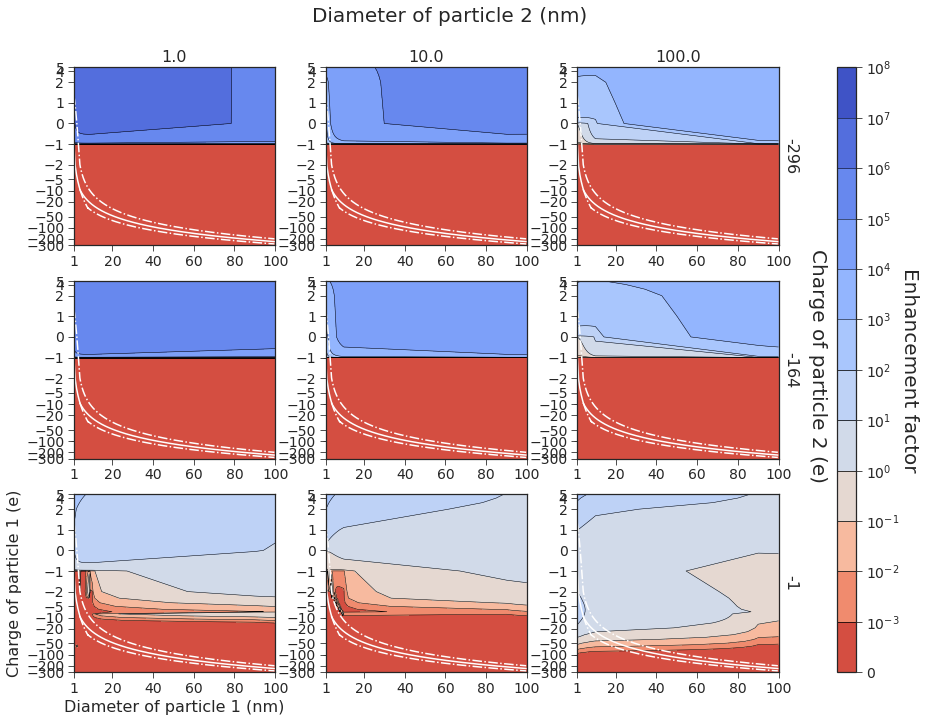

In [22]:
# ll=[0, 1, 2]
ll=[0, 18, 39]
ql=[0, 50, 93]
m4X.set_grid(0, 39, 0, 99)
m4X.logvmax = 8
m4X.logvmin = -4
m4X.minvalue = 10**m4X.logvmin
m4X.contour_width = 0.5
#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4X.plot_fsymlog(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 120, 20)],
                   yaxticks=[-300, -200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4, 5],
                   mean_charge=qms)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:479: RuntimeWarning: invalid value encountered in less


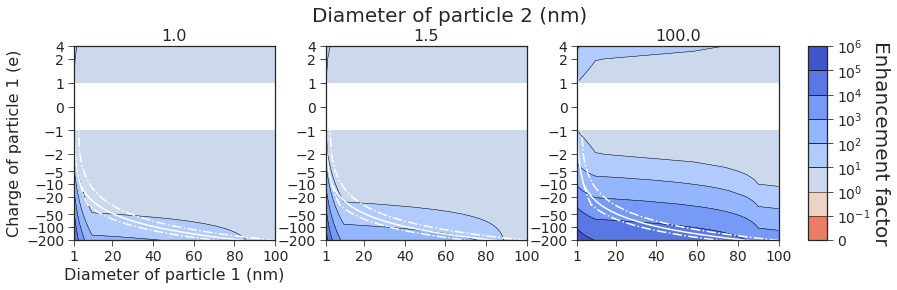

In [19]:
# ll=[0, 1, 2]
ll=[0, 1, 39]
ql=[94]
m4X.set_grid(0, 39, 0, 99)

m4X.logvmax = 6
#m4X.logvmin = -3
m4X.logvmin = -2
m4X.minvalue = 10**m4X.logvmin

m4X.contour_width = 0.5

#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4X.plot_fsymlog(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                  vsize=1.5*2.25, hsize=4.5*3,
                  mean_charge=qms)

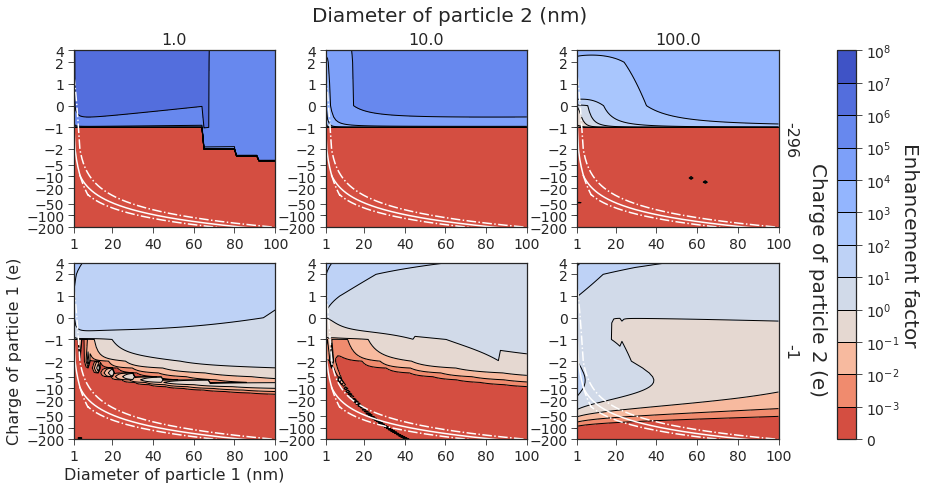

In [9]:
# ll=[0, 1, 2]
ll=[0, 9, 99]
ql=[0, 295]
m4X.set_grid(0, 99, 0, 301)

m4X.logvmax = 8
m4X.logvmin = -4
m4X.minvalue = 10**m4X.logvmin

m4X.contour_width = 1.0

#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4X.plot_fsymlog(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5],
                  vsize=3*2.25, hsize=4.5*3,
                  mean_charge=qms)

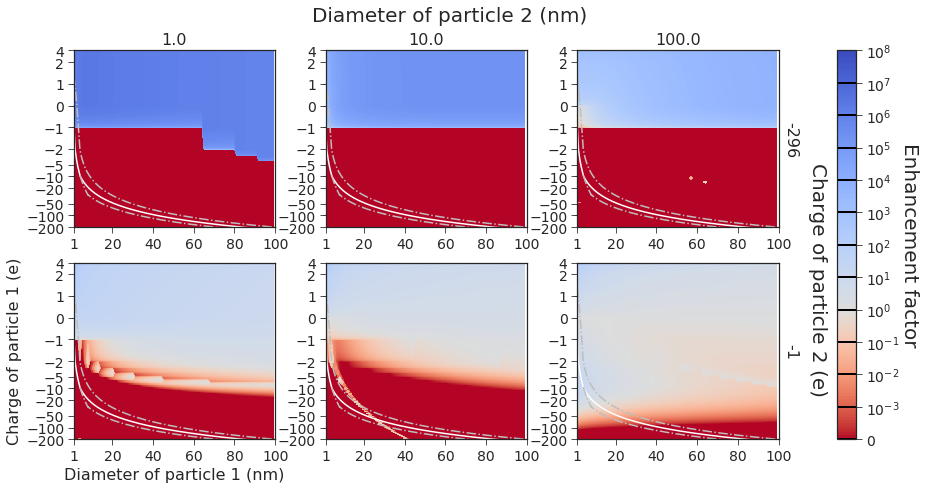

In [38]:
# ll=[0, 1, 2]
ll=[0, 9, 99]
ql=[0, 295]
m4X.set_grid(0, 99, 0, 301)

m4X.logvmax = 8
m4X.logvmin = -4
m4X.minvalue = 10**m4X.logvmin

m4X.contour_width = 0.0
#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4X.plot_fsymlog_c(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5],
                  vsize=3*2.25, hsize=4.5*3,
                  mean_charge=qms)

In [9]:
# ll=[0, 1, 2]
ll=[0, 9, 99]
ql=[0, 132, 295]
m4X.set_grid(0, 99, 0, 301)
m4X.logvmax = 8
m4X.logvmin = -4
m4X.minvalue = 10**m4X.logvmin
m4X.contour_width = 0.5
#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4X.plot_fsymlog(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-300, -200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5],
                  mean_charge=qms)

IndexError: index 2 is out of bounds for axis 0 with size 2

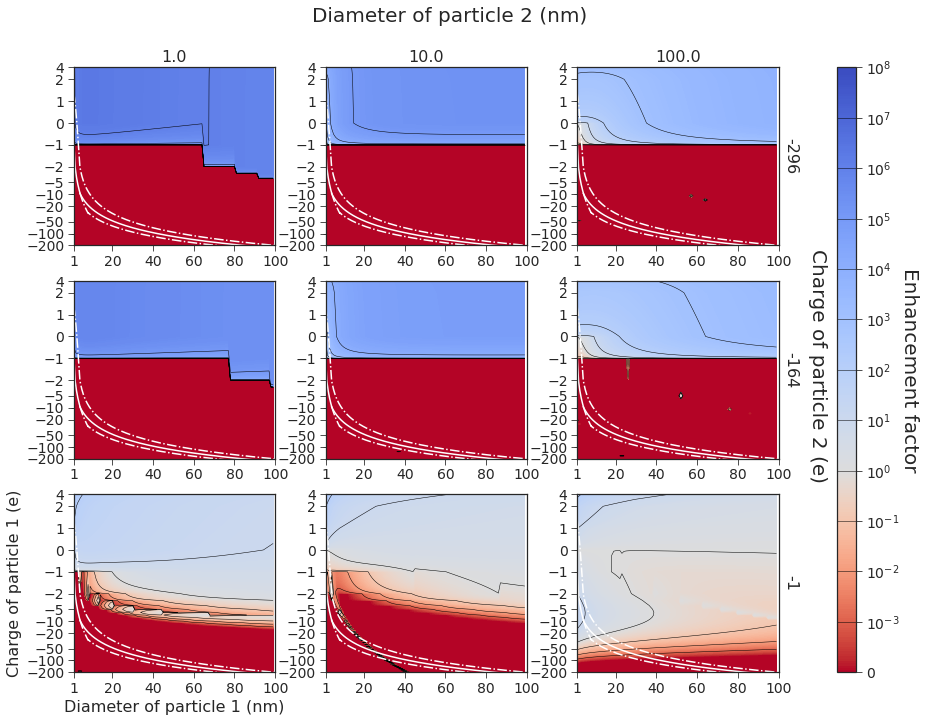

In [64]:
# ll=[0, 1, 2]
ll=[0, 9, 99]
ql=[0, 132, 295]
m4X.set_grid(0, 99, 0, 301)
m4X.logvmax = 8
m4X.logvmin = -4
m4X.minvalue = 10**m4X.logvmin
m4X.contour_width = 0.5
#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4X.plot_fsymlog_c(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                  mean_charge=qms)

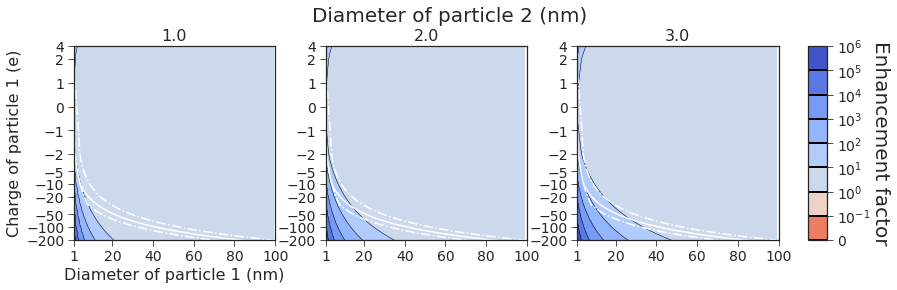

In [50]:
# ll=[0, 1, 2]
ll=[0, 1, 2]
ql=[296]
m4X.set_grid(0, 99, 0, 301)

m4X.logvmax = 6
#m4X.logvmin = -3
m4X.logvmin = -2
m4X.minvalue = 10**m4X.logvmin

m4X.contour_width = 0.5

#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4X.plot_fsymlog(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                  vsize=1.5*2.25, hsize=4.5*3,
                  mean_charge=qms)

In [31]:
#m4d = mplot4d("grid-linear-IPA-force-50-adjusted")
#m4d = mplot4d("grid-linear-IPA-force-50")
m4d = mplot4d("special-allcharges-linear-MPCIPA")
# m4d2 = mplot4d("grid-geom-IPA-force-50-adjusted")
#m4d2 = mplot4d("grid-geom-IPAMPC-force-50")
m4d2 = mplot4d("grid-geom-IPAMPC-force-50")
#m4dmpc = mplot4d("grid-linear-MPC20")
m4dmpc = mplot4d("special-allcharges-linear-MPC")
m4dmpc2 = mplot4d("grid-geom-MPC20")
#m4dc = mplot4d("grid-linear-coulomb")
m4dc = mplot4d("special-allcharges-linear-Coulomb")
m4dc2 = mplot4d("grid-geom-coulomb")

In [8]:
# read mean charge and distribution width
probable_charge = np.load('probable_charge.npz')

In [9]:
# mean charge x, y values
xmean = probable_charge['diams_tofile']
ymean = probable_charge['charge_tofile']

In [10]:
# upper limit of charge width, shares sames x as mean charge
yup = probable_charge['charge_up_tofile']

In [11]:
# lower limit of charge
xbottom = probable_charge['diams_bottom_tofile']
ybottom = probable_charge['charge_bottom_tofile']

In [12]:
# xmean = xmean[ymean>m4d.qpivots[0]]
# ymean = ymean[ymean>m4d.qpivots[0]]
# ymean = ymean[xmean<m4d.dpivots[-2]]
# xmean = xmean[xmean<m4d.dpivots[-2]]

In [13]:
# trim arrays from m4d objects x and y axis limits
def prune_charge(x, y, m):
    xp = x[y>m.qpivots[0]]
    yp = y[y>m.qpivots[0]]
    yp = yp[xp<m.dpivots[-1]]
    xp = xp[xp<m.dpivots[-1]]
    return xp, yp

In [14]:
xqmean, yqmean = prune_charge(xmean, ymean, m4X)

In [15]:
xqup, yqup = prune_charge(xmean, yup, m4X)

In [16]:
xqbottom, yqbottom = prune_charge(xbottom, ybottom, m4X)

In [18]:
qms = [xqmean, yqmean, xqup, yqup, xqbottom, yqbottom]

In [19]:
for q in qms:
    print(len(q))

300
300
300
300
291
291


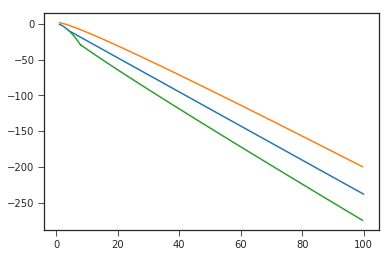

In [70]:
fig, ax = plt.subplots()
ax.plot(xmean, ymean)
ax.plot(xqup, yqup)
ax.plot(xqbottom, yqbottom)
plt.show()

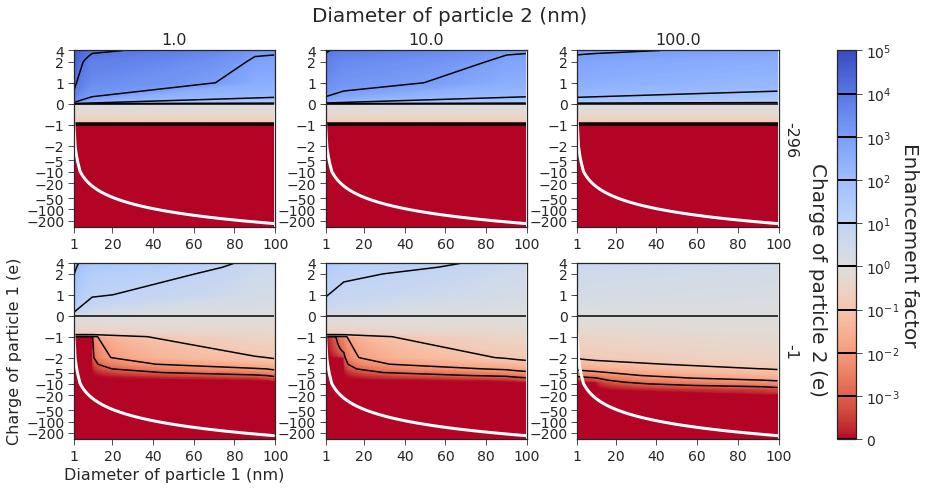

In [20]:
# ll=[0, 1, 2]
ll=[0, 18, 39]
ql=[0, 93]
m4dc.set_grid(0, 39, 0, 99)

m4dc.logvmax = 5
m4dc.logvmin = -4
m4dc.minvalue = 10**m4dc.logvmin

#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4dc.plot_fsymlog_c(ll, ql, filename='fig3', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                  vsize=3*2.25, hsize=4.5*3,
                  mean_charge=[xmean, ymean])

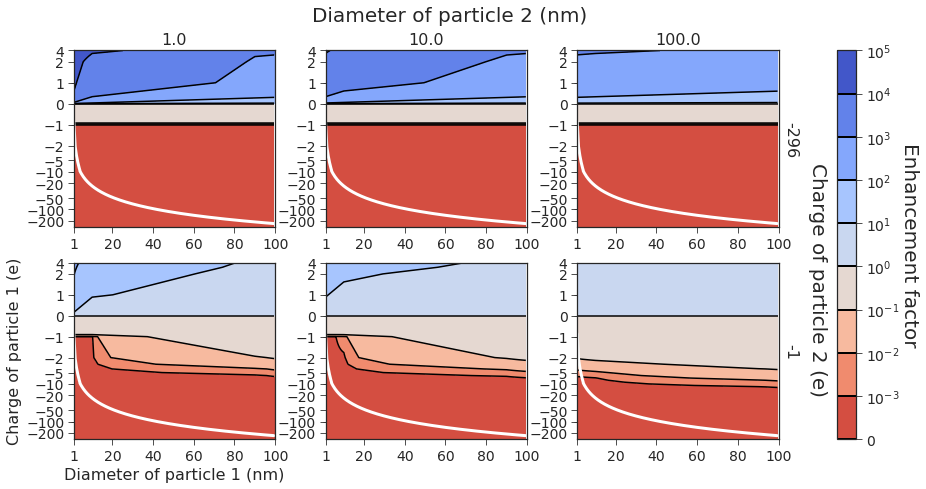

In [21]:
# ll=[0, 1, 2]
ll=[0, 18, 39]
ql=[0, 93]
m4dc.set_grid(0, 39, 0, 99)

m4dc.logvmax = 5
m4dc.logvmin = -4
m4dc.minvalue = 10**m4dc.logvmin

#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4dc.plot_fsymlog(ll, ql, filename='fig3-2', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                  vsize=3*2.25, hsize=4.5*3,
                  mean_charge=[xmean, ymean])

# Neutrals

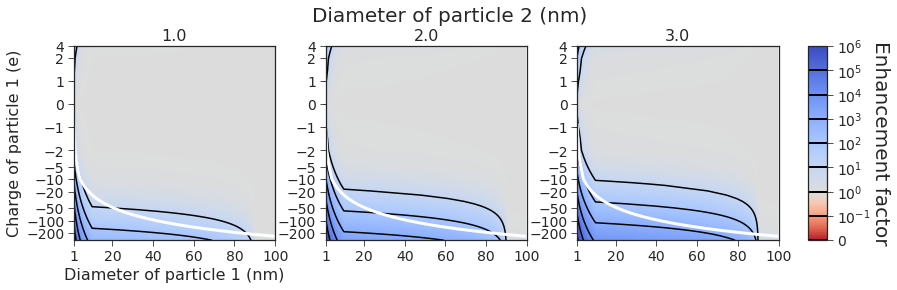

In [9]:
# ll=[0, 1, 2]
ll=[0, 2, 4]
ql=[94]
m4dmpc.set_grid(0, 39, 0, 99)
m4dmpc.logvmax = 6
#m4dmpc.logvmin = -3
m4dmpc.logvmin = -2
m4dmpc.minvalue = 10**m4dmpc.logvmin

#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4dmpc.plot_fsymlog_c(ll, ql, filename='fig4', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                  vsize=1.5*2.25, hsize=4.5*3,
                  mean_charge=[xmean, ymean])

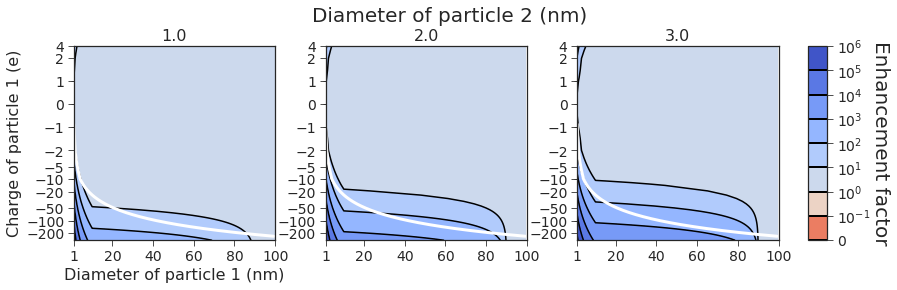

In [10]:
# ll=[0, 1, 2]
ll=[0, 2, 4]
ql=[94]
m4dmpc.set_grid(0, 39, 0, 99)

m4dmpc.logvmax = 6
#m4dmpc.logvmin = -3
m4dmpc.logvmin = -2
m4dmpc.minvalue = 10**m4dmpc.logvmin

#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4dmpc.plot_fsymlog(ll, ql, filename='fig4-2', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                  vsize=1.5*2.25, hsize=4.5*3,
                  mean_charge=[xmean, ymean])

# MPC results

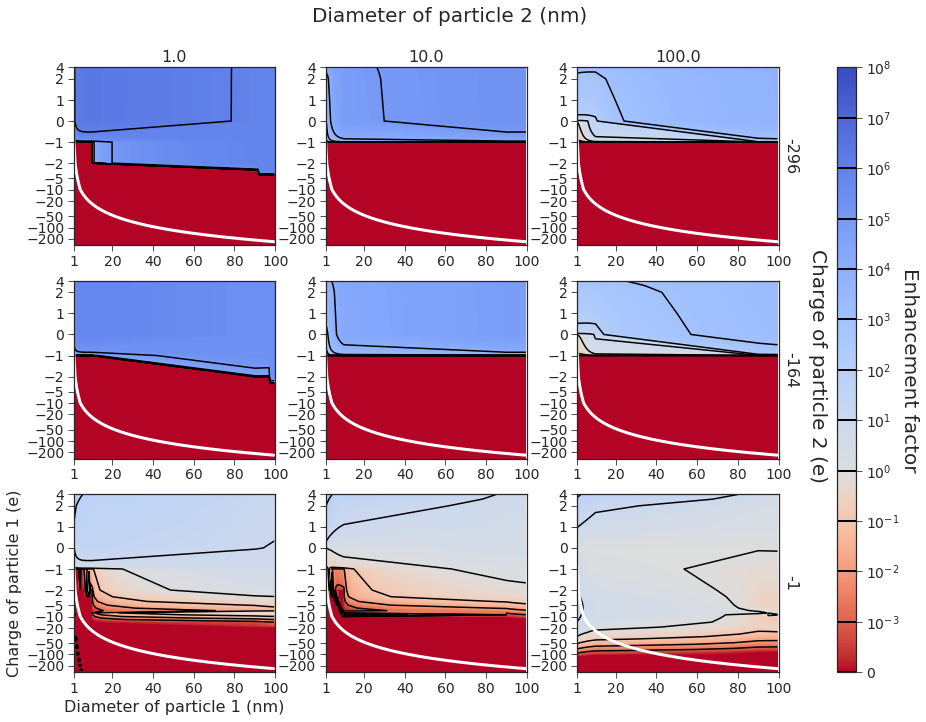

In [11]:
# ll=[0, 1, 2]
ll=[0, 18, 39]
ql=[0, 50, 93]
m4dmpc.set_grid(0, 39, 0, 99)
m4dmpc.logvmax = 8
m4dmpc.logvmin = -4
m4dmpc.minvalue = 10**m4dmpc.logvmin
#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4dmpc.plot_fsymlog_c(ll, ql, filename='fig5', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                     mean_charge=[xmean, ymean])

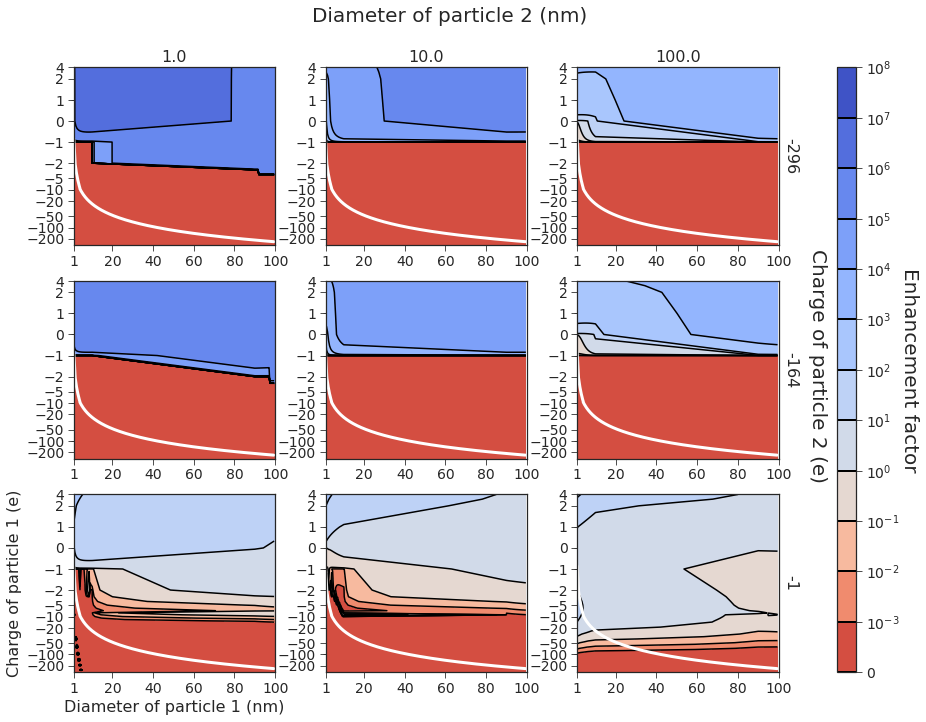

In [12]:
# ll=[0, 1, 2]
ll=[0, 18, 39]
ql=[0, 50, 93]
m4dmpc.set_grid(0, 39, 0, 99)
m4dmpc.logvmax = 8
m4dmpc.logvmin = -4
m4dmpc.minvalue = 10**m4dmpc.logvmin
#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4dmpc.plot_fsymlog(ll, ql, filename='fig5-2', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                     mean_charge=[xmean, ymean])

# MPC + IPA

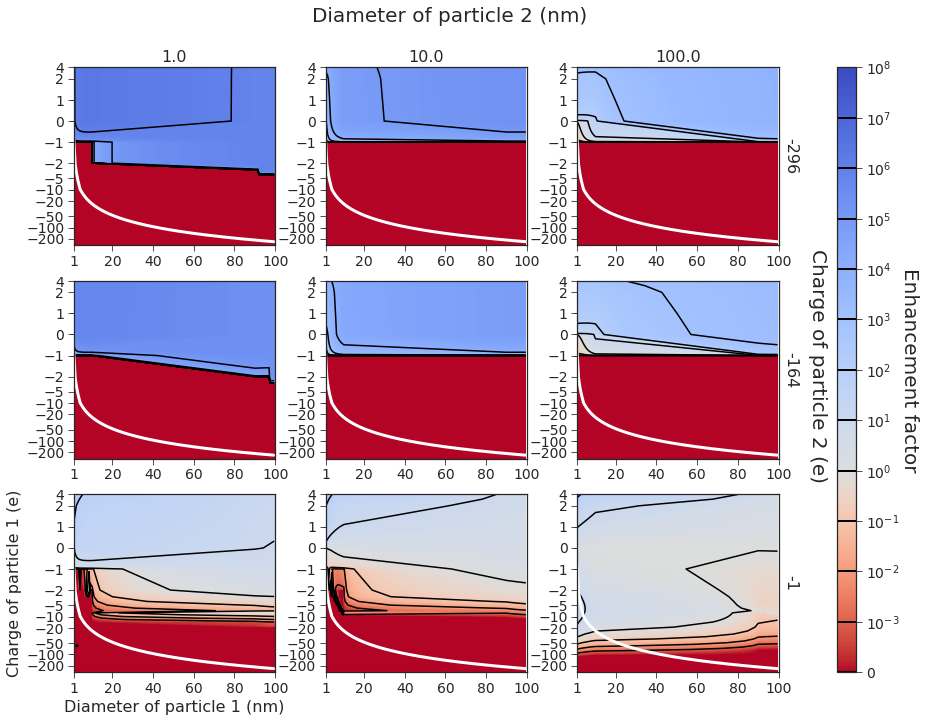

In [13]:
# ll=[0, 1, 2]
ll=[0, 18, 39]
ql=[0, 50, 93]
m4d.set_grid(0, 39, 0, 99)
m4d.logvmax = 8
m4d.logvmin = -4
m4d.minvalue = 10**m4d.logvmin
#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4d.plot_fsymlog_c(ll, ql, filename='fig6', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                     mean_charge=[xmean, ymean])

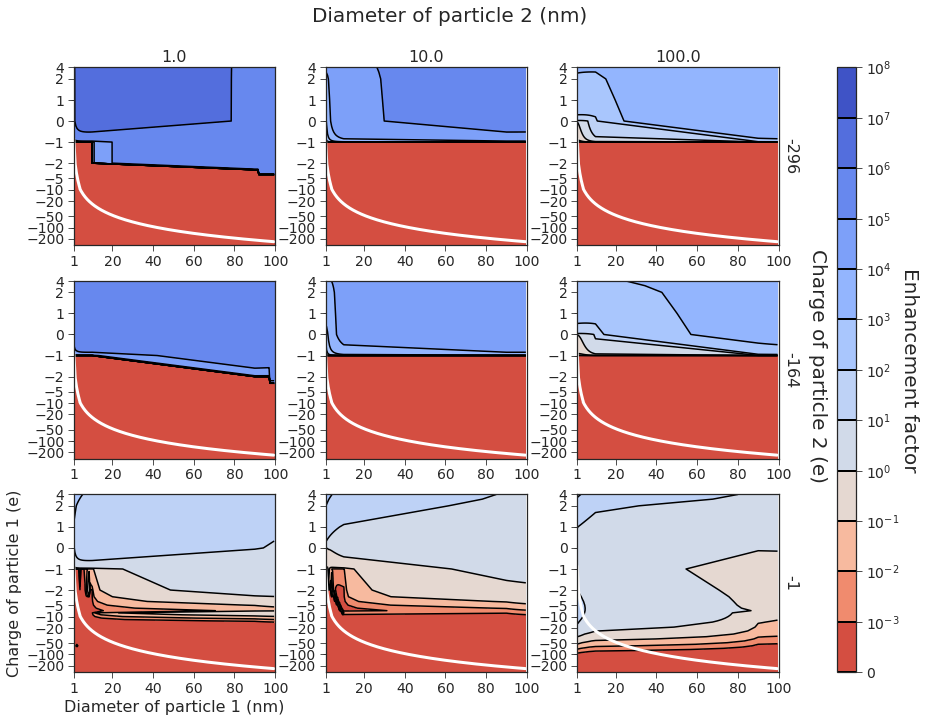

In [14]:
# ll=[0, 1, 2]
ll=[0, 18, 39]
ql=[0, 50, 93]
m4d.set_grid(0, 39, 0, 99)
m4d.logvmax = 8
m4d.logvmin = -4
m4d.minvalue = 10**m4d.logvmin
#test.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4d.plot_fsymlog(ll, ql, filename='fig6-2', xaxticks=[1, *np.arange(20, 120, 20)],
                  yaxticks=[-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 4],
                     mean_charge=[xmean, ymean])